In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import itertools as it
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import time

In [2]:
# Inherit Dataset
# Override __len__ and __getitem__
# Read in file in init 
# Process in getitem
# Brian's in_file is './SGB_data/SGB_spectrum.hdf5' 
# Keys are 'X' and 'X_test'
# Image pixel count is 10291 pixels

class Img_Dataset(Dataset):
    def __init__(self, in_file, key, tensor=False):
        self.tensor = transform
        self.f = h5py.File(in_file, 'r')
        self.n_images, self.ny, self.nx, self.depth = self.f[key].shape
        self.key = key
        
    def __getitem__(self, index):
        input = self.f[self.key][index, :,:]
        input = input.astype('float32').reshape(self.depth,
                                               self.ny,
                                               self.nx)
        if self.tensor:
            input = torch.from_numpy(input)
        return input
    
    def __len__(self):
        return self.n_images

Some image stats to know...
Number of images: 470941
Image width: 41
Image height: 251
Pixel values max 0.08 and min 0.00


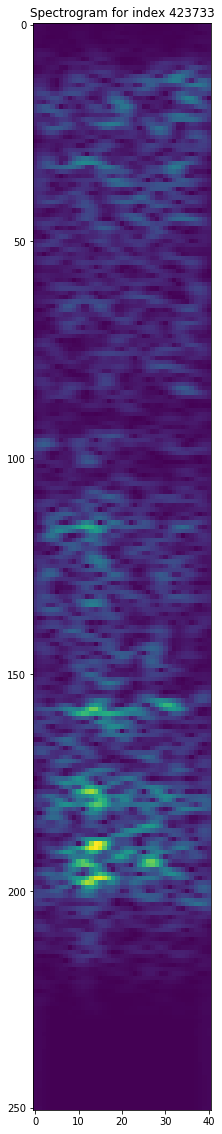

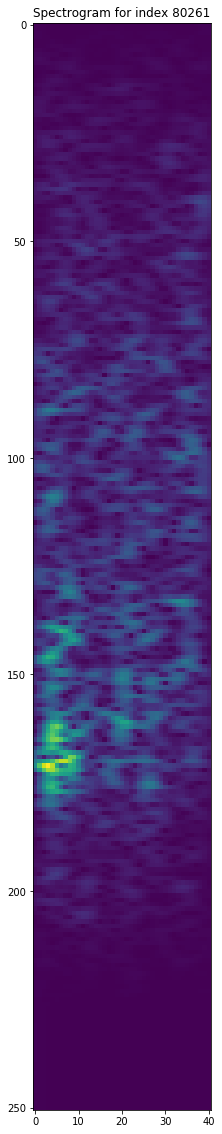

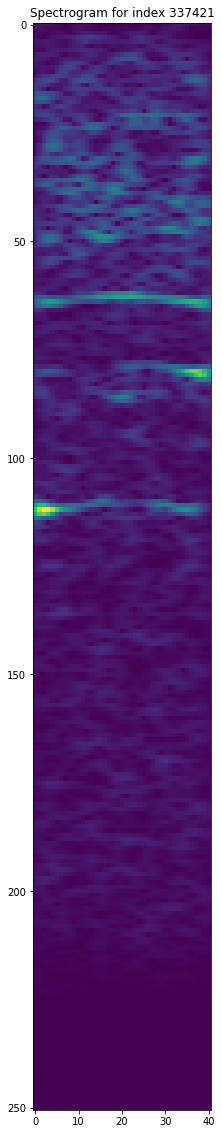

In [3]:
FILE = './SGB_data/SGB_spectrum.hdf5'
KEY_TRAIN = 'X'
KEY_TEST = 'X_test'
myData = Img_Dataset(FILE, KEY_TRAIN)
print('Some image stats to know...')
print(f'Number of images: {myData.n_images}')
print(f'Image width: {myData.nx}')
print(f'Image height: {myData.ny}')
mx = myData[0][0,:,:].max()
mn = myData[0][0,:,:].min()
print(f'Pixel values max {mx:.2f} and min {mn:.2f}')
# Print some samples to test the dataset
test_group = np.random.randint(0, myData.n_images, size=3)
plt.ion()
for i in test_group:
    plt.figure(figsize=(10,20))
    plt.imshow(myData[i].reshape(251,41))
    plt.title(f'Spectrogram for index {i}')
    plt.show()
plt.ioff()

In [4]:
def calculate_filter_size(height, width, pad, dilation, k_size, stride):
    hOut = 1.0 + (height + 2*pad[0]- dilation[0]*(k_size[0]-1)-1)/stride[0]
    wOut = 1.0 + (width + 2*pad[1]- dilation[1]*(k_size[1]-1)-1)/stride[1]

    return hOut, wOut

C_O = calculate_filter_size(251,41,
                      pad=(0,0),
                      dilation=(1,1),
                      k_size=(3,3),
                      stride=(2,2))

MP_O = calculate_filter_size(125,20,
                      pad=(0,0),
                      dilation=(1,1),
                      k_size=(3,3),
                      stride=(2,1))

C_I = calculate_filter_size(62,18,
                      pad=(0,0),
                      dilation=(1,1),
                      k_size=(3,3),
                      stride=(2,1))

MP_I = calculate_filter_size(20,16,
                      pad=(0,0),
                      dilation=(1,1),
                      k_size=(3,2),
                      stride=(1,2))
C = calculate_filter_size(18,8,
                      pad=(0,0),
                      dilation=(1,1),
                      k_size=(5,3),
                      stride=(1,1))

MP = calculate_filter_size(14,6,
                      pad=(0,0),
                      dilation=(1,1),
                      k_size=(3,2),
                      stride=(1,2))
print(f'Filter sizes outer, CNN {C_O} MaxPool {MP_O}')
print(f'Filter sizes inner, CNN {C_I} MaxPool {MP_I}')
print(f'Filter sizes inner, CNN {C} MaxPool {MP}')

Filter sizes outer, CNN (125.0, 20.0) MaxPool (62.0, 18.0)
Filter sizes inner, CNN (30.5, 16.0) MaxPool (18.0, 8.0)
Filter sizes inner, CNN (14.0, 6.0) MaxPool (12.0, 3.0)


In [5]:
BATCH_SIZE        = 400  # This is N in torch documentation!!!
NUM_WORKERS       = 3
NUM_O             = 4
NUM_I             = 3
LR                = 0.001
WD                = 1e-5
EPOCH             = 4
FULL_BATCH        = int(np.floor(470941/100))-1
dset              = Img_Dataset(FILE, KEY_TRAIN, True)
img_loader        = torch.utils.data.DataLoader( dset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_WORKERS)
tset              = Img_Dataset(FILE, KEY_TEST, True)
img_loader_test   = torch.utils.data.DataLoader( tset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_WORKERS)

In [6]:
class ENC(nn.Module):
    def __init__(self):
        super(ENC, self).__init__()
        #self.E_dOuter = nn.Dropout(p=0.1)
        self.E_cnnOuter = nn.Conv2d(in_channels=1,
                                    out_channels=NUM_O,
                                    kernel_size=(3,3),
                                    stride=(2,2),
                                    padding=(0,0))
        self.E_eOuter   = nn.ELU()
        self.E_mpOuter  = nn.MaxPool2d(kernel_size=(3,3), 
                                    stride=(2,1),
                                    padding=(0,0),
                                    dilation=(1,1),
                                    return_indices=True)
        self.E_bnOuter  = nn.BatchNorm2d(NUM_O)
        #self.E_dInner   = nn.Dropout(p=0.1)
        self.E_cnnInner = nn.Conv2d(in_channels=NUM_O,
                                    out_channels=NUM_I,
                                    kernel_size=(5,3),
                                    stride=(3,1),
                                    padding=(0,0))
        self.E_bnInner  = nn.BatchNorm2d(NUM_I)
        self.E_eInner   = nn.ELU()
        self.E_mpInner  = nn.MaxPool2d(kernel_size=(3,2), 
                                    stride=(1,2),
                                    padding=(0,0),
                                    dilation=(1,1),
                                    return_indices=True)

    
    def forward(self, input):
        #x          = self.E_dOuter(input)
        x          = self.E_cnnOuter(input)
        #print(f' enc CO {x.size()}')
        x          = self.E_bnOuter(x)
        x          = self.E_eOuter(x)
        x, o_index = self.E_mpOuter(x)
        #print(f' enc MO {x.size()}')
        #x          = self.E_dInner(x)
        x          = self.E_cnnInner(x)
        #print(f' enc CI {x.size()}')
        x          = self.E_bnInner(x)
        x          = self.E_eInner(x)
        x, i_index = self.E_mpInner(x)
        #print(f' enc MI {x.size()}')
        return x, o_index, i_index
        

class DEC(nn.Module):
    def __init__(self):
        super(DEC, self).__init__()
        self.D_mpInner  = nn.MaxUnpool2d(kernel_size=(3,2),
                                        stride=(1,2),
                                        padding=(0,0))
        self.D_eInner   = nn.ELU()
        self.D_bnInner  = nn.BatchNorm2d(NUM_I)
        self.D_cnnInner = nn.ConvTranspose2d(NUM_I, NUM_O,
                                             kernel_size=(5,3),
                                             stride=(3,1),
                                             padding=(0,0))
        self.D_mpOuter  = nn.MaxUnpool2d(kernel_size=(3,3),
                                        stride=(2,1),
                                        padding=(0,0))
        self.D_eOuter   = nn.ELU()
        self.D_bnOuter  = nn.BatchNorm2d(NUM_O)
        self.D_cnnOuter = nn.ConvTranspose2d(NUM_O, 1,
                                             kernel_size=(3,3),
                                             stride=(2,2),
                                             padding=(0,0))
        self.sig        = nn.Sigmoid()
        
    def forward(self, input, o_index, i_index):              # ,i_index... was changed
        x = self.D_mpInner(input, i_index)
        x = self.D_eInner(x)
        #print(f' dec MI {x.size()}')
        x = self.D_bnInner(x)
        x = self.D_cnnInner(x)
        #print(f' dec CI {x.size()}')
        x = self.D_mpOuter(x, o_index)
        x = self.D_eOuter(x)
        #print(f' dec MO {x.size()}')
        x = self.D_bnOuter(x)
        x = self.D_cnnOuter(x)
        #print(f' dec CO {x.size()}')
        x = self.sig(x)
        return torch.clamp(x, min=0.0, max=1.0 )
    
enc = ENC().cuda()
dec = DEC().cuda()

In [7]:
loss_list = []
test_list = []
chain = it.chain(enc.parameters(), dec.parameters())
optimizer  = torch.optim.RMSprop(chain, lr=LR, alpha=0.4, momentum=0.5)
loss_fn = nn.MSELoss(reduction='mean')
for epoch in range(EPOCH):
    epoch_loss = 0.0
    for i,j in tqdm(enumerate(img_loader)):
        #if i>5:  #This if statement is required
        #    break;     #when you insert a linear latent space
        enc.train()
        dec.train()
        X = j.cuda()
        target = j.detach().cuda()
        encoded, outer, inner = enc(X) 
        #print(f'loop encoded size{encoded.size()}')
        decoded = dec(encoded, outer, inner)     
        loss = loss_fn(decoded, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_list.append(epoch_loss/float(i))
    print(f'Epoch: {epoch}/{EPOCH}    Loss: {loss_list[-1]:.6f}')
    with torch.no_grad():
        enc.eval()
        dec.eval()
        test_error = 0.0
        for i,j in enumerate(img_loader_test):
            X = j.cuda()
            target = j.detach().cuda()
            encoded, outer, inner = enc(X)  
            decoded = dec(encoded, outer, inner)     
            loss_test = loss_fn(decoded, target)
            test_error += loss_test.item()
    test_list.append(test_error)

1178it [01:04, 18.26it/s]

Epoch: 0/4    Loss: 0.027167



1178it [01:17, 15.12it/s]

Epoch: 1/4    Loss: 0.000068



1178it [01:05, 18.09it/s]

Epoch: 2/4    Loss: 0.000062



1178it [01:04, 18.27it/s]

Epoch: 3/4    Loss: 0.000062


In [8]:
loss_list

[0.02716696547551194,
 6.760789639656843e-05,
 6.156789614218023e-05,
 6.187163246095758e-05]

In [9]:
test_list

[0.010620924185786862,
 0.008273941777588334,
 0.008228505008446518,
 0.008331560846272623]

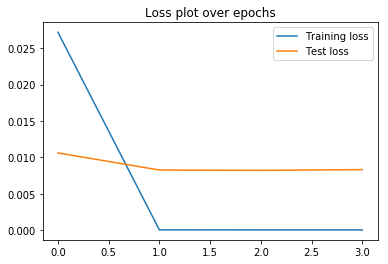

In [10]:
plt.figure()
plt.title('Loss plot over epochs')
plt.plot(loss_list,label='Training loss')
plt.plot(test_list, label='Test loss')
plt.legend()
plt.show()

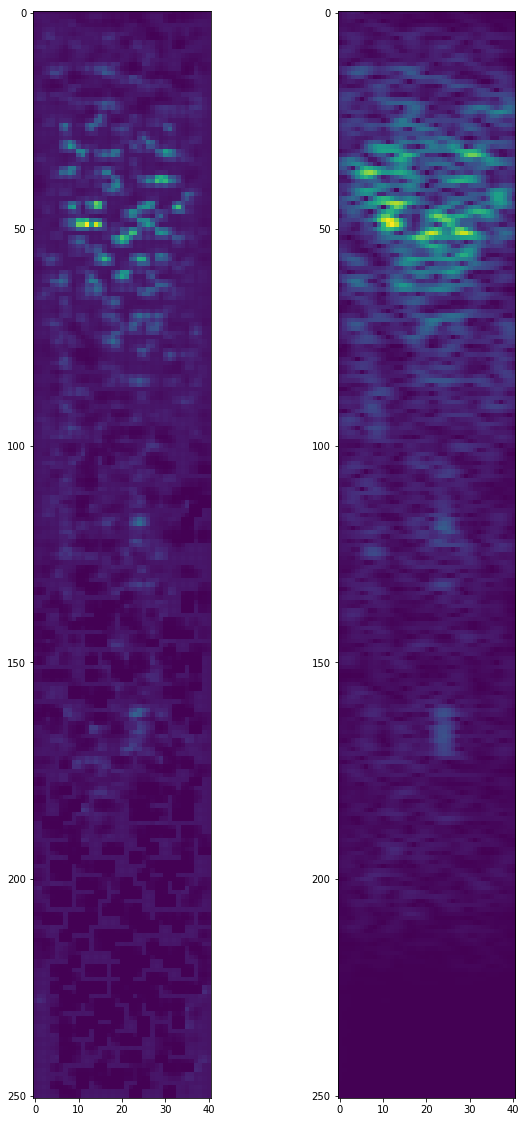

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.14


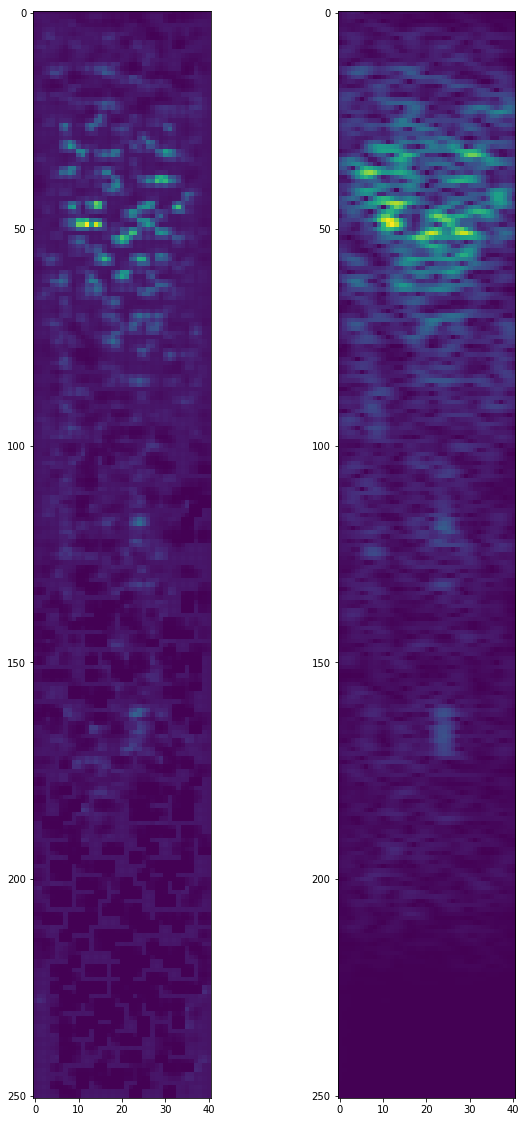

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.14


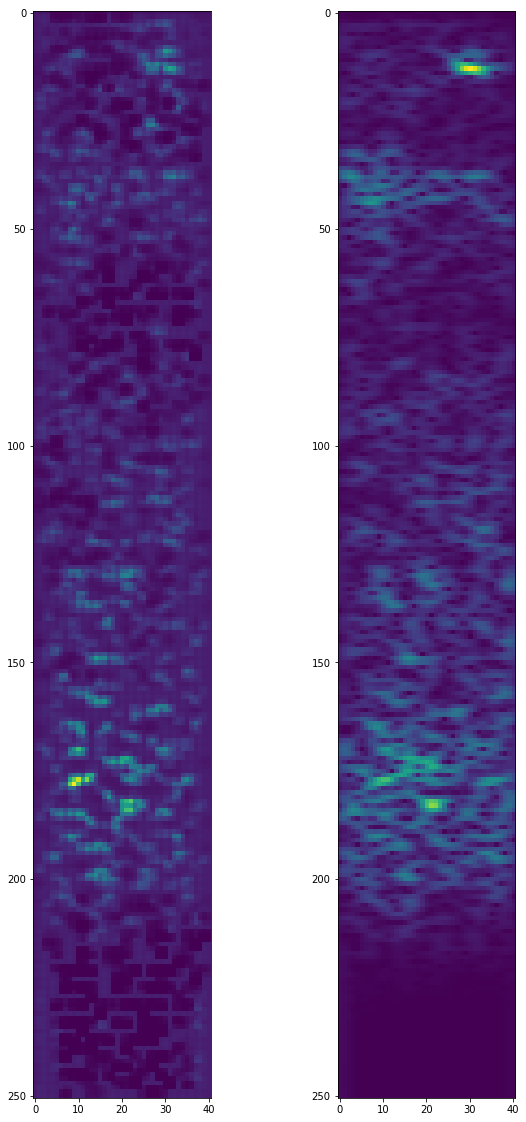

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.10


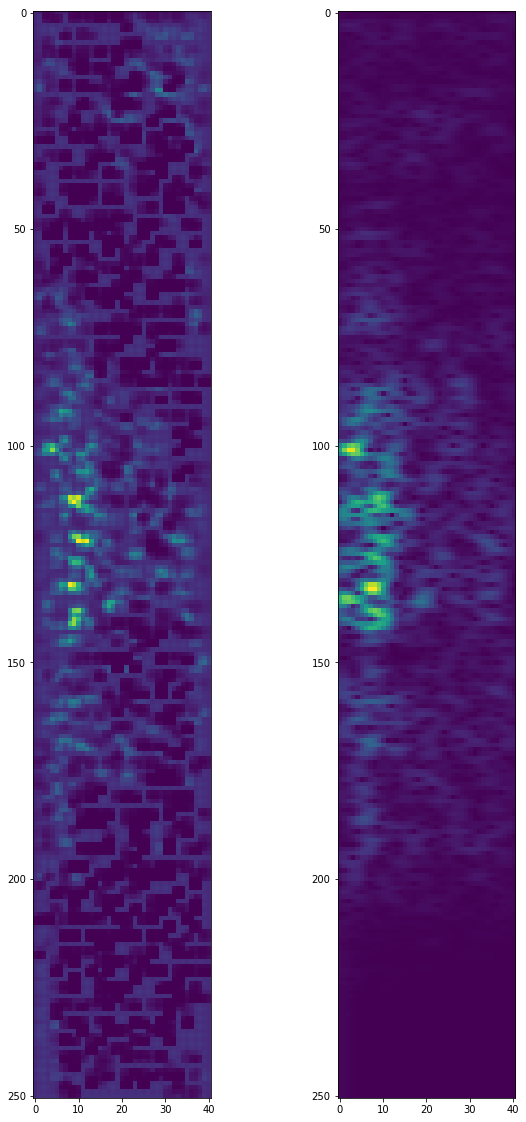

Ave value encoded 0.01        target 0.00 encoded min         0.00 encoded max 0.06


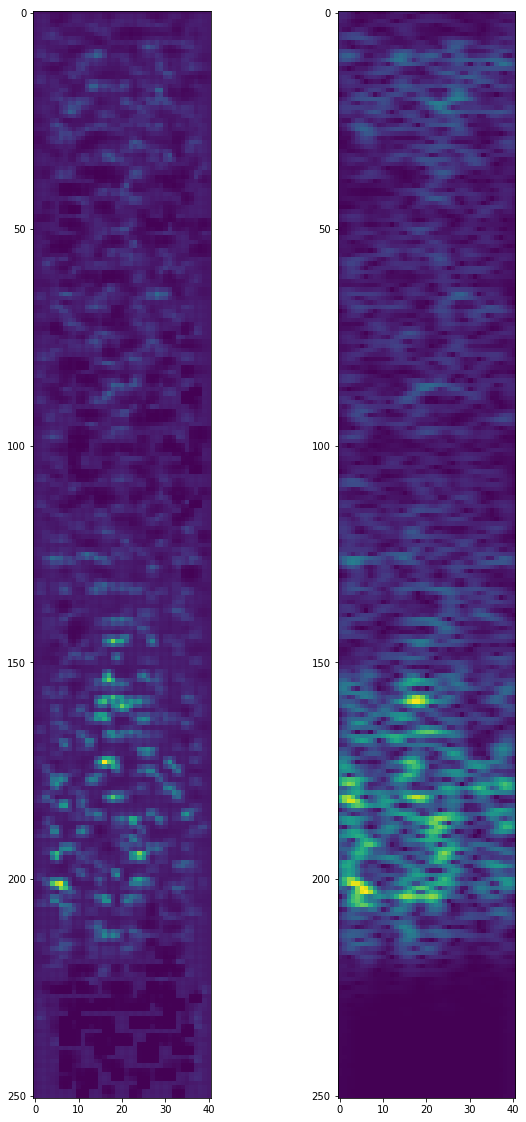

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.11


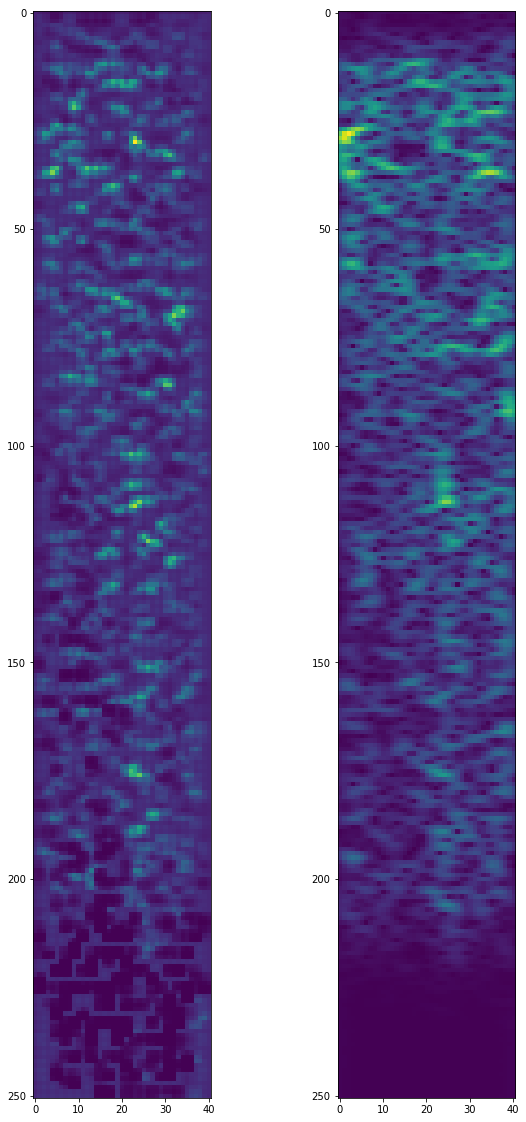

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.07


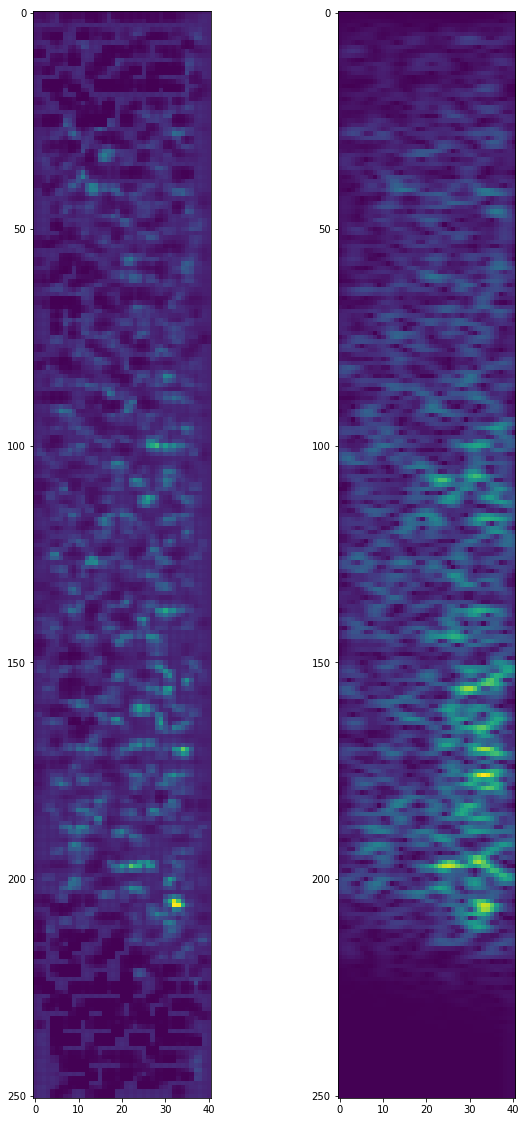

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.08


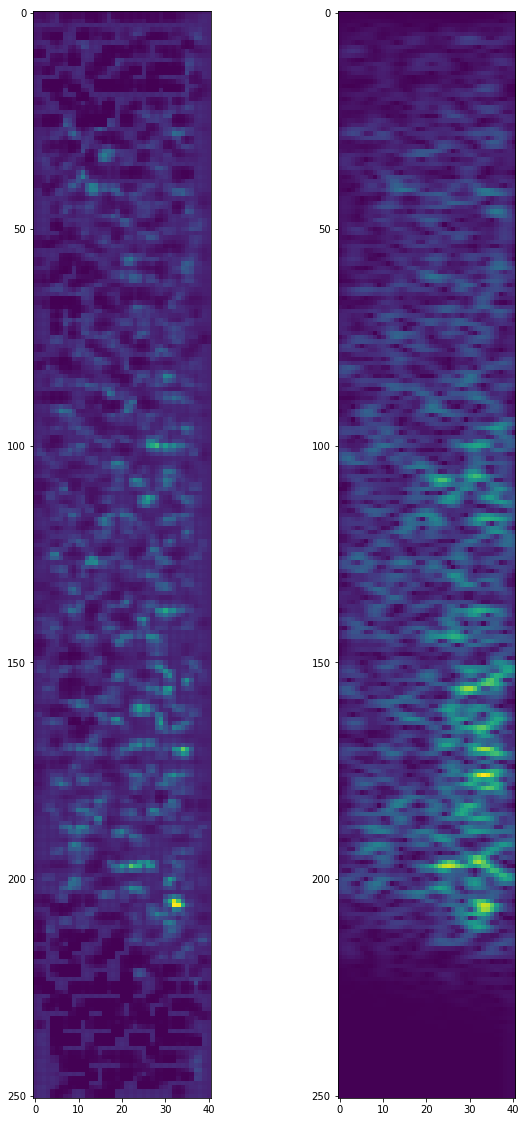

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.08


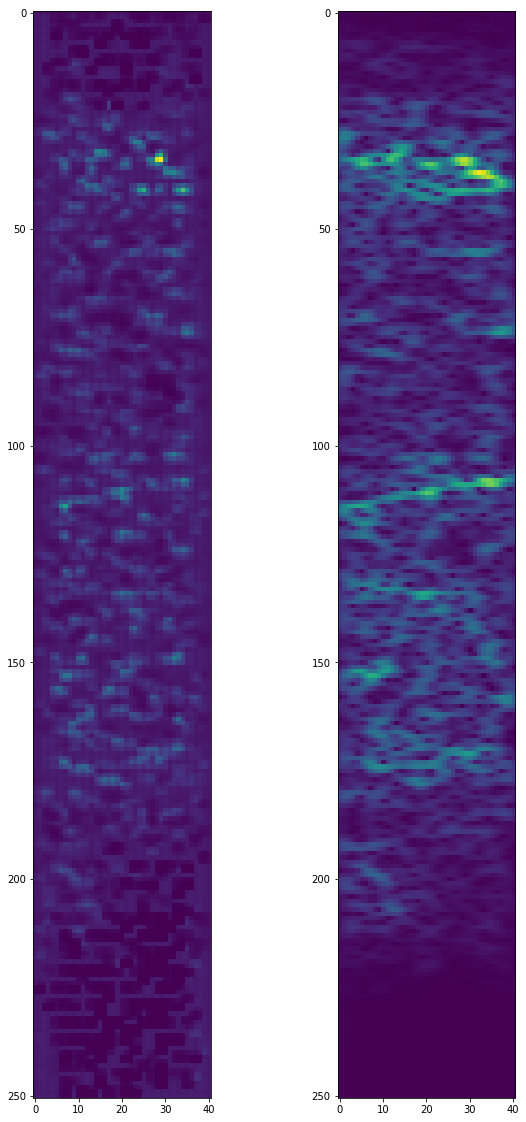

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.12


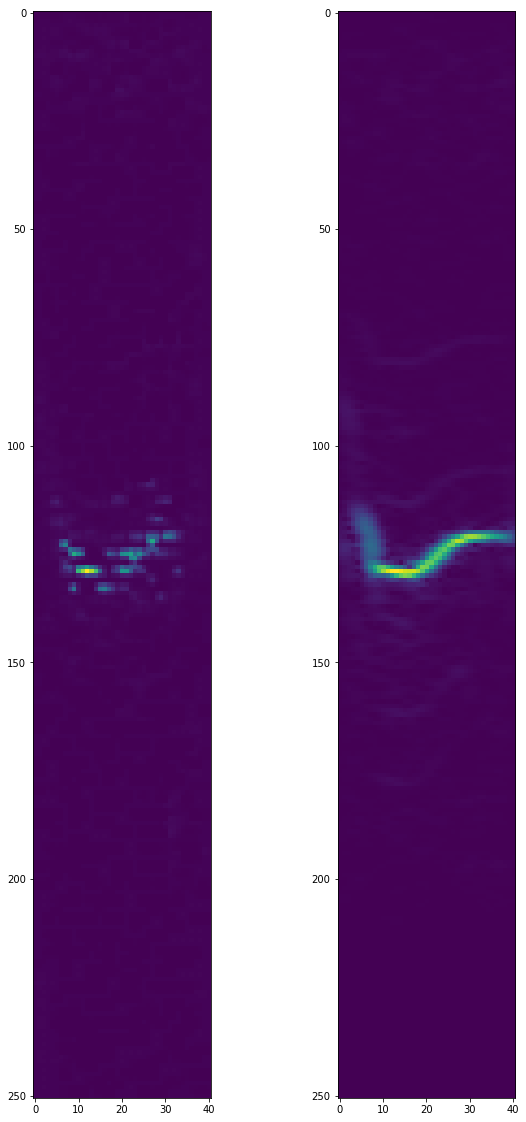

Ave value encoded 0.01        target 0.01 encoded min         0.00 encoded max 0.82


In [11]:
plt.ion()
for imgIdx in np.random.randint(0,41,10):
    imgEnc = decoded[imgIdx].detach().cpu().numpy().reshape((251,41))
    imgTar = target[imgIdx].detach().cpu().numpy().reshape((251,41))
    plt.figure(figsize=(10,20))
    ax1 = plt.subplot(121)
    imE = ax1.imshow(imgEnc)
    ax2 = plt.subplot(122)
    imT = ax2.imshow(imgTar)
    plt.show()
    plt.close()
    print(f'Ave value encoded {imgEnc.mean():.2f}\
        target {imgTar.mean():.2f} encoded min \
        {imgEnc.min():.2f} encoded max {imgEnc.max():.2f}')
plt.ioff() 

In [12]:
temp_list = []
with torch.no_grad():
        enc.eval()
        for i,j in enumerate(img_loader_test):
            X = j.cuda()
            target = j.detach().cuda()
            encoded, outer, inner = enc(X)
            chunk = encoded.view(400, 3*18*8).cpu()
            temp_list.append(chunk.numpy())

In [13]:
print('Filter size: ', 3*18*8)

Filter size:  432


In [14]:
temp_mat = np.array(temp_list).reshape(125*400, 3*18*8)

In [15]:
np.savetxt('./enc_test_best_sm.pkl', temp_mat)

# Clustering

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
import time

In [17]:
PATH = './enc_test_best_sm.pkl'

def get_Z(path):
    d = np.loadtxt(path)
    dist = pdist(d, metric='euclidean')
    del d
    return dist


In [18]:
s = time.time()
dist_condensed = get_Z(PATH)
e = time.time() - s
print(f'Calculation time {e}')

Calculation time 346.61514377593994


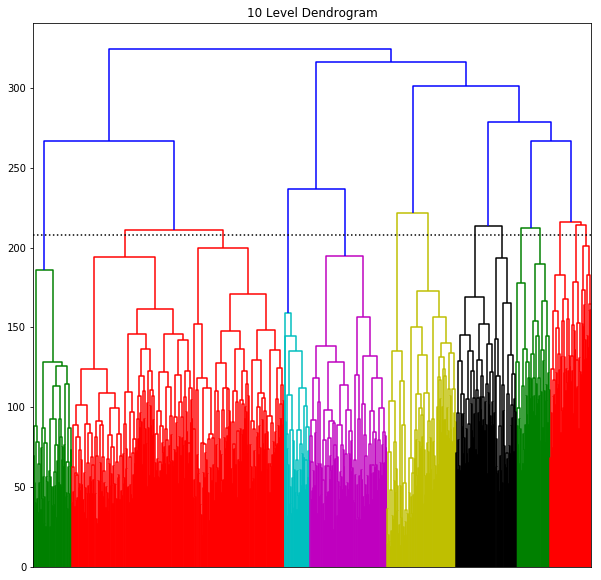

In [19]:
Z = hierarchy.linkage(dist_condensed, 'complete')

plt.figure(figsize=(10,10))
plt.title('10 Level Dendrogram')
dend = hierarchy.dendrogram(Z=Z,p=10,
                           truncate_mode='level',
                           orientation='top',
                           show_leaf_counts=True,
                           no_labels=True)
plt.hlines(208,0,49999,colors='k',linestyles='dotted')
plt.show()

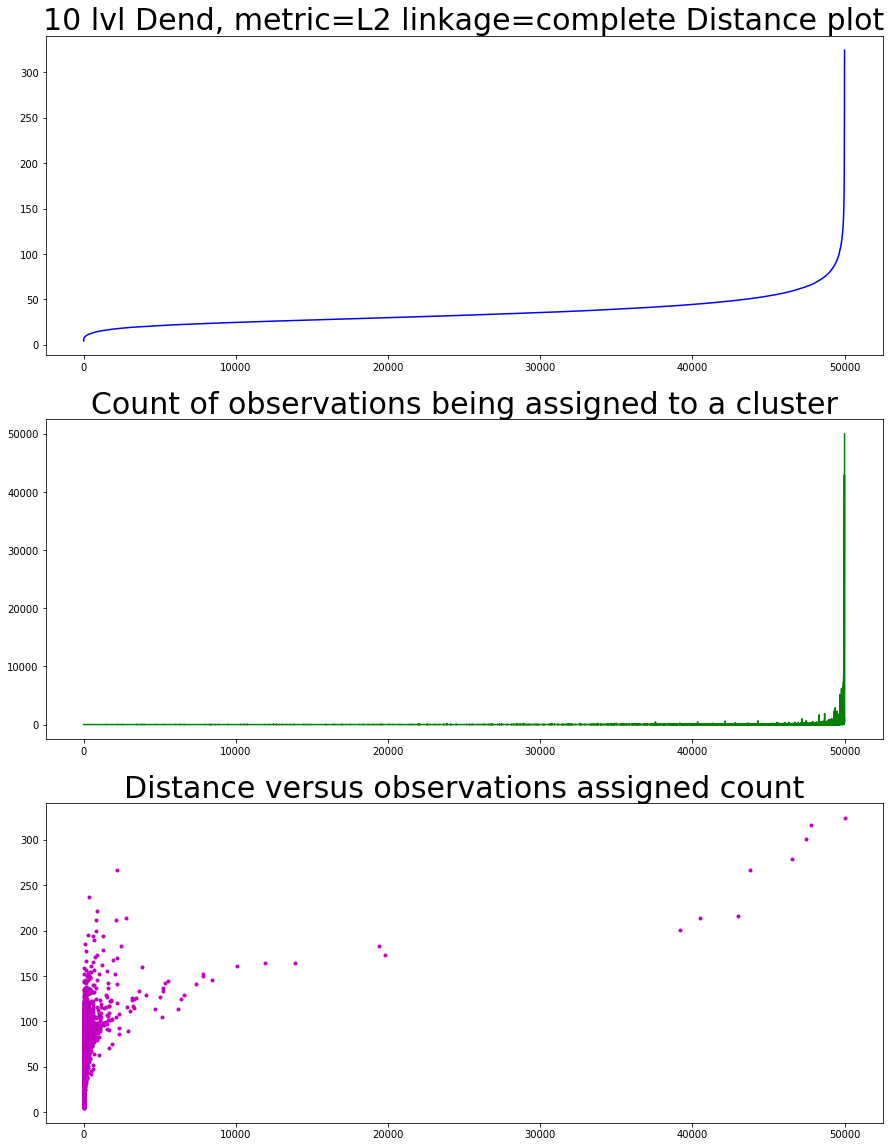

In [20]:
x = np.linspace(0,49998, num=49999)
plt.figure(figsize=(15,20))
plt.subplot(311)
plt.title(f'10 lvl Dend, metric=L2 linkage=complete Distance plot').set_fontsize(30)
_ = plt.plot(x,Z[:,2],'b')
plt.subplot(312)
plt.title('Count of observations being assigned to a cluster').set_fontsize(30)
_ = plt.plot(x,Z[:,3],'g')
plt.subplot(313)
plt.title('Distance versus observations assigned count').set_fontsize(30)
_=plt.plot(Z[:,3],Z[:,2],'m.')
plt.show()
plt.close()

In [21]:
from scipy.cluster.hierarchy import fcluster
max_d = 208
clusters = fcluster(Z, max_d, criterion='distance')
np.savetxt('./l2_cluster_labels_best_sm.pkl', clusters)

# Sample images

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = h5py.File('./SGB_data/SGB_spectrum.hdf5','r')
data_mat = f['X_test'][:,:,:,0]
labels_l2 = np.loadtxt('l2_cluster_labels_best_sm.pkl')
clst_unique_l2 = np.unique(labels_l2)
df = pd.DataFrame(data=data_mat.reshape(50000,-1))
df['l2_labels'] = labels_l2
df['outlier'] = np.zeros(50000)
l2 = df['l2_labels'].unique().tolist()

In [ ]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
# -1 is outlier 1 otherwise

clf = IsolationForest(behaviour='new',
                      max_samples=100,
                      bootstrap=True,
                      n_jobs=3,
                      random_state=rng,
                      contamination='auto')
for i in l2:
    df_working = df.loc[df['l2_labels']==i,:]
    data_mat = df_working.values
    idxs = df_working.index.values
    outlier_labels = clf.fit_predict(data_mat[:,:-3])
    for j in range(len(idxs)):
        df.loc[idxs[j],'outlier'] = outlier_labels[j]
        

Cluster 1.0 size (50, 10293) ##################################################


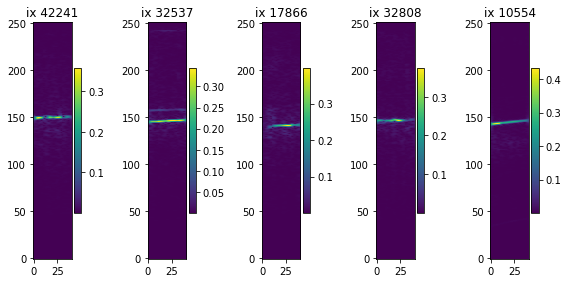

Cluster 2.0 size (1237, 10293) ##################################################


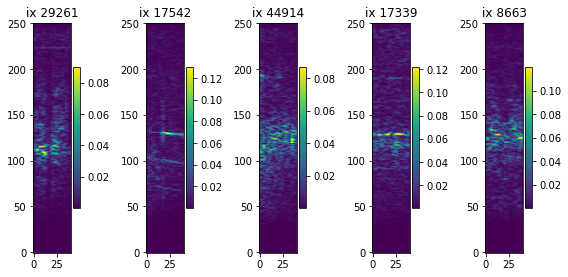

Cluster 3.0 size (797, 10293) ##################################################


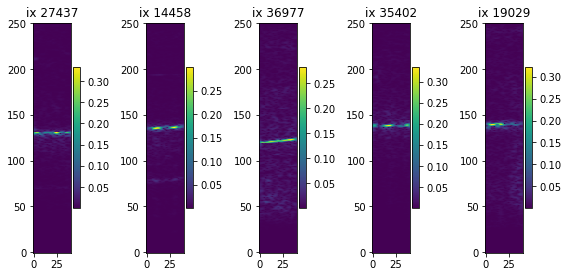

Cluster 4.0 size (37, 10293) ##################################################


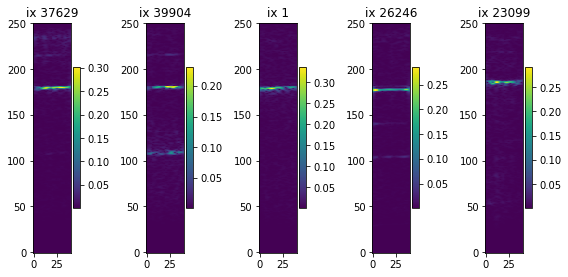

Cluster 5.0 size (249, 10293) ##################################################


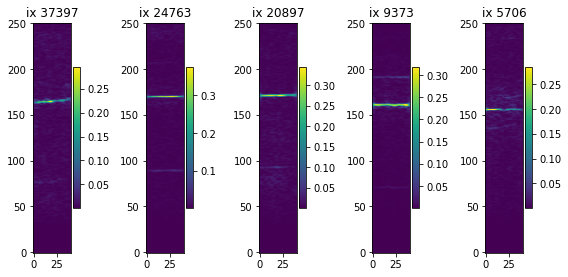

Cluster 6.0 size (11, 10293) ##################################################


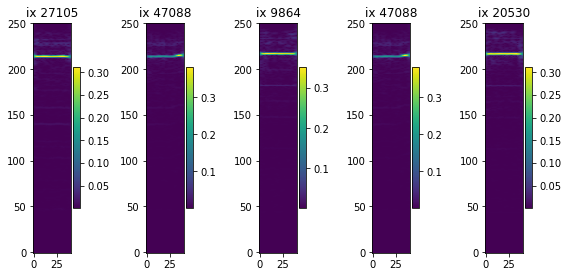

Cluster 7.0 size (813, 10293) ##################################################


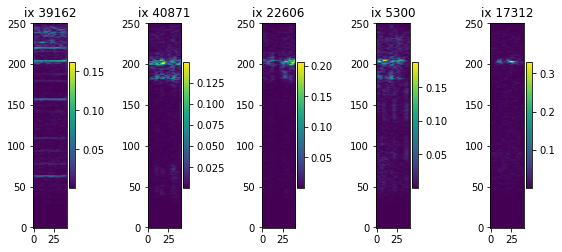

Cluster 8.0 size (2103, 10293) ##################################################


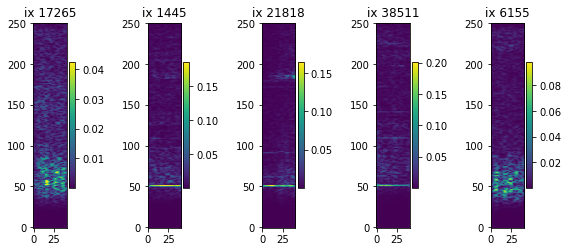

Cluster 9.0 size (604, 10293) ##################################################


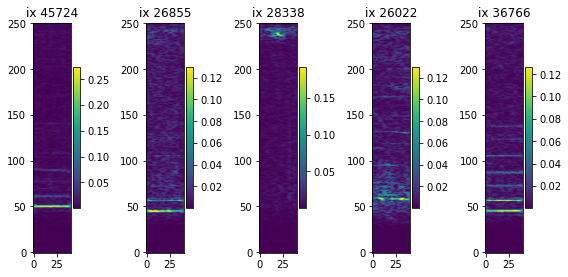

Cluster 10.0 size (132, 10293) ##################################################


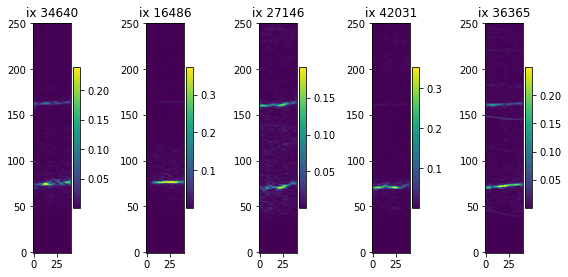

Cluster 11.0 size (633, 10293) ##################################################


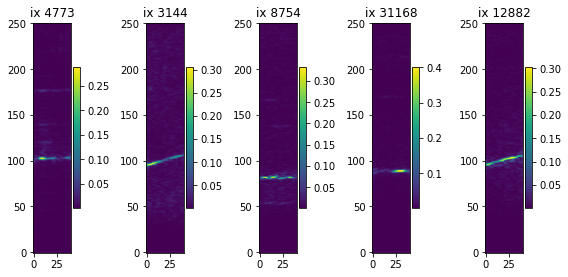

Cluster 12.0 size (2414, 10293) ##################################################


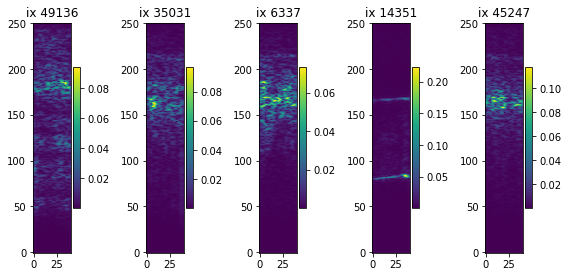

Cluster 13.0 size (1234, 10293) ##################################################


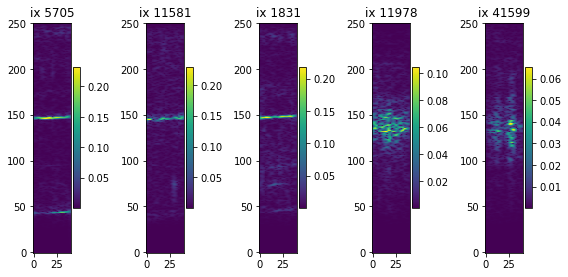

Cluster 14.0 size (38994, 10293) ##################################################


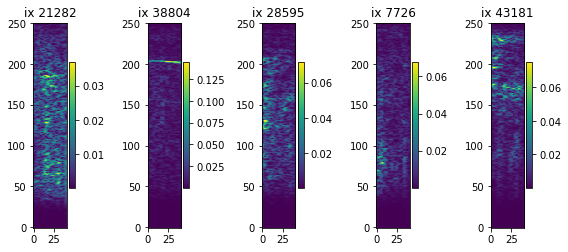

In [8]:

plt.ion()
for lbl in clst_unique_l2:
    df_temp = df.loc[(df['l2_labels']==lbl) & (df['outlier']==1.0),:]
    rand_idxs = np.random.randint(0,len(df_temp.index),5)
    counter = 1
    imgs = df_temp.values
    print(f'Cluster {lbl} size {imgs.shape} ' +'#'*50)
    plt.subplots(1,5,figsize=(8,10))
    for i in rand_idxs:
        img = imgs[i][:-2]
        plt.subplot(1,5,counter)
        plt.imshow(np.flipud(img.reshape(251,41)))
        plt.gca().invert_yaxis()
        plt.title(f'ix {df_temp.index[i]}')
        plt.colorbar()
        counter += 1
        plt.tight_layout()
    plt.show()
    plt.close()
plt.ioff()

Cluster 1.0 size (16, 10293) ##################################################


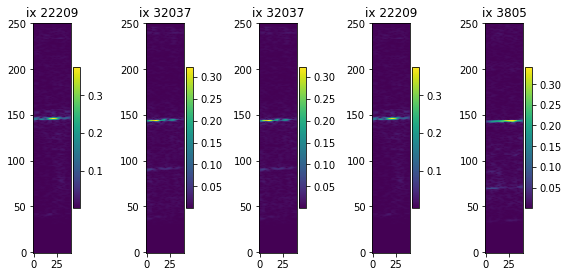

Cluster 2.0 size (52, 10293) ##################################################


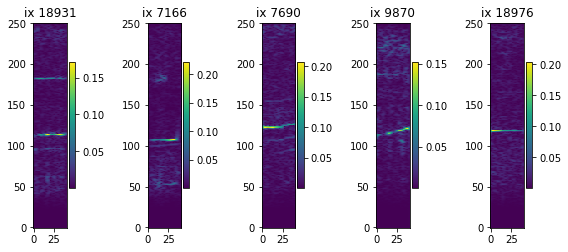

Cluster 3.0 size (33, 10293) ##################################################


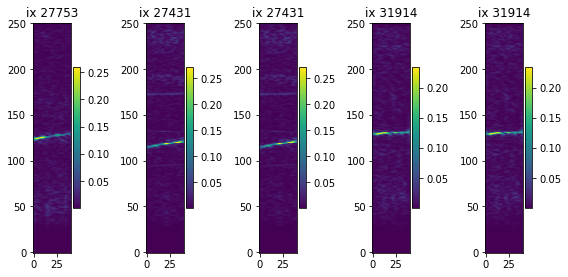

Cluster 4.0 size (22, 10293) ##################################################


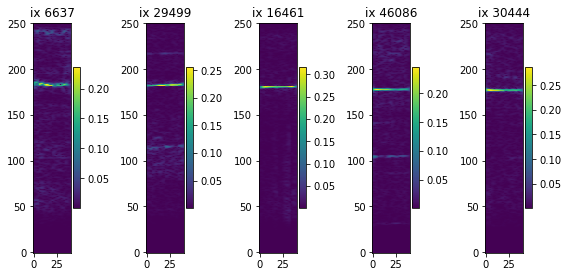

Cluster 5.0 size (26, 10293) ##################################################


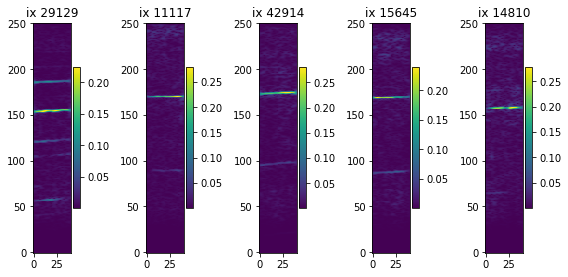

Cluster 6.0 size (23, 10293) ##################################################


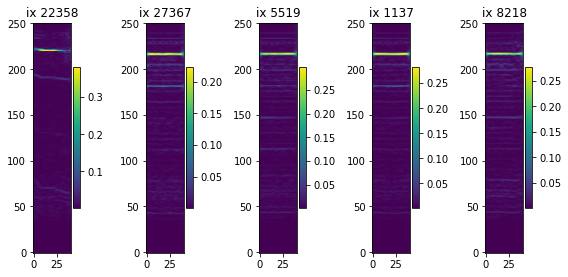

Cluster 7.0 size (56, 10293) ##################################################


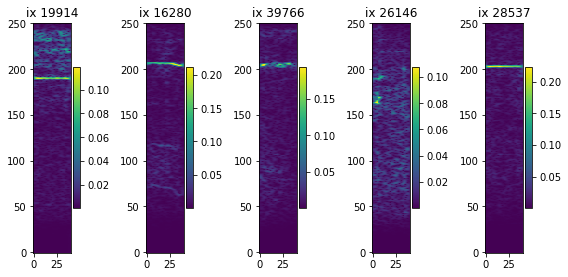

Cluster 8.0 size (79, 10293) ##################################################


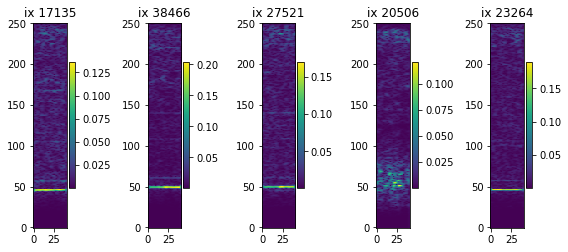

Cluster 9.0 size (16, 10293) ##################################################


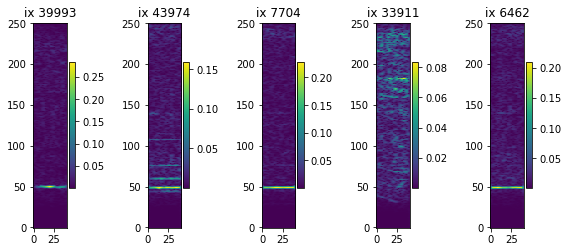

Cluster 10.0 size (14, 10293) ##################################################


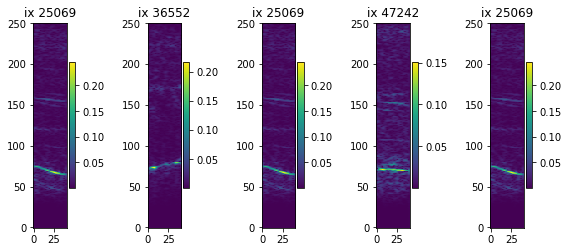

Cluster 11.0 size (24, 10293) ##################################################


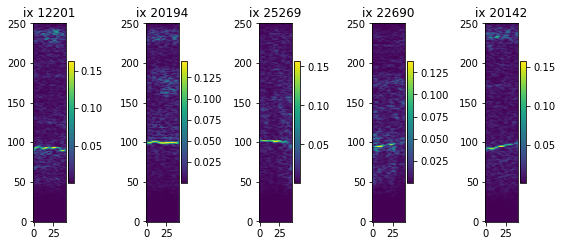

Cluster 12.0 size (62, 10293) ##################################################


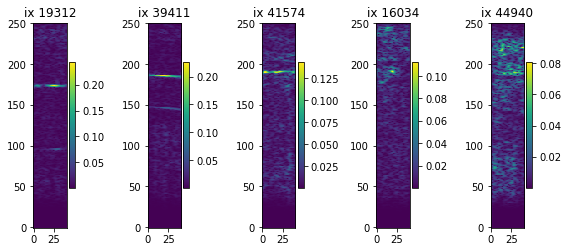

Cluster 13.0 size (47, 10293) ##################################################


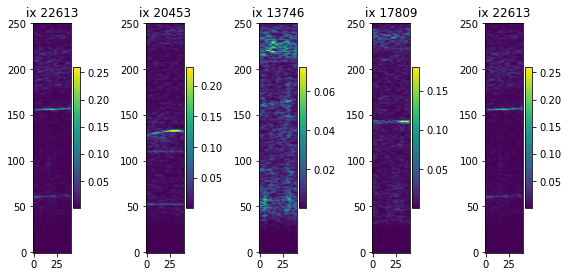

Cluster 14.0 size (222, 10293) ##################################################


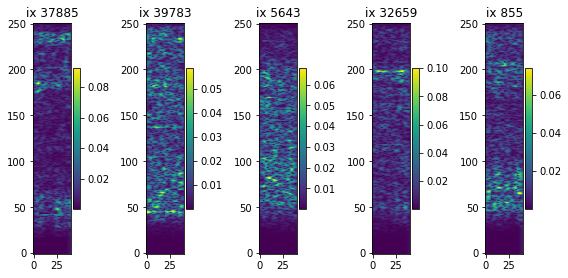

In [9]:

plt.ion()
for lbl in clst_unique_l2:
    df_temp = df.loc[(df['l2_labels']==lbl) & (df['outlier']==-1.0),:]
    try:
        rand_idxs = np.random.randint(0,len(df_temp.index),5)
    except ValueError:
        print('No values')
        continue
    counter = 1
    imgs = df_temp.values
    print(f'Cluster {lbl} size {imgs.shape} ' +'#'*50)
    plt.subplots(1,5,figsize=(8,10))
    for i in rand_idxs:
        img = imgs[i][:-2]
        plt.subplot(1,5,counter)
        plt.imshow(np.flipud(img.reshape(251,41)))
        plt.gca().invert_yaxis()
        plt.title(f'ix {df_temp.index[i]}')
        plt.colorbar()
        counter += 1
        plt.tight_layout()
    plt.show()
    plt.close()
plt.ioff()